In [1]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [5]:
#Defining Directories for test,validation and training data
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

### Data preproposessing and visualization

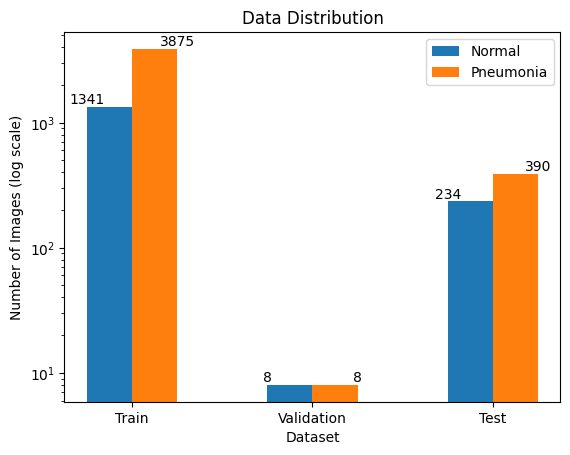

In [6]:
# Get the number of normal and pneumonia images in each dataset
normal_train_imgs = os.listdir(os.path.join(train_dir, "NORMAL"))
pneumonia_train_imgs = os.listdir(os.path.join(train_dir,"PNEUMONIA"))
num_normal_train = len(normal_train_imgs)
num_pneumonia_train = len(pneumonia_train_imgs)

normal_val_imgs = os.listdir(os.path.join(val_dir, "NORMAL"))
pneumonia_val_imgs = os.listdir(os.path.join(val_dir,"PNEUMONIA"))
num_normal_val = len(normal_val_imgs)
num_pneumonia_val = len(pneumonia_val_imgs)

normal_test_imgs = os.listdir(os.path.join(test_dir, "NORMAL"))
pneumonia_test_imgs = os.listdir(os.path.join(test_dir,"PNEUMONIA"))
num_normal_test = len(normal_test_imgs)
num_pneumonia_test = len(pneumonia_test_imgs)

# Create a bar chart
bar_width = 0.25
x1 = [1, 2, 3]
x2 = [i + bar_width for i in x1]
normal_values = [num_normal_train, num_normal_val, num_normal_test]
pneumonia_values = [num_pneumonia_train, num_pneumonia_val, num_pneumonia_test]
plt.bar(x1, normal_values, width=bar_width, label='Normal')
plt.bar(x2, pneumonia_values, width=bar_width, label='Pneumonia')
plt.title('Data Distribution')
plt.xticks([i + bar_width/2 for i in x1], ['Train', 'Validation', 'Test'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images (log scale)')
plt.yscale('log')
plt.legend()

# Add the actual values on top of the bars
for i in range(len(x1)):
    plt.text(x1[i] - bar_width/2, normal_values[i], str(normal_values[i]), ha='center', va='bottom')
    plt.text(x2[i] + bar_width/2, pneumonia_values[i], str(pneumonia_values[i]), ha='center', va='bottom')

plt.show()

In [7]:
#define image parameters
batch_size = 32
image_size = (160,160)

In [8]:
#creating a train and validation generator
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    image_size = image_size,
    #color_mode = "grayscale",
    seed = 123)

validation_ds =tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size = batch_size,
    image_size = image_size,
    #color_mode = "grayscale",
    seed = 123)

test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size = batch_size,
    image_size = image_size,
    #color_mode = "grayscale",
    seed = 123)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [9]:
for images, labels in test_ds.take(1):
    print(f'Image shape: {images.shape}')
    print(f'Image data type: {images.dtype}')

Image shape: (32, 160, 160, 3)
Image data type: <dtype: 'float32'>


In [10]:
#Identify class names
class_names=train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [11]:
#Aototuning the data(to prefetch the data to reduce time during the learnig)
AUTOTUNE =tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
#Normalization of the data and setting the number of classes
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
num_classes = 2

0.0 0.9996814


(32, 160, 160, 3)
(32,)


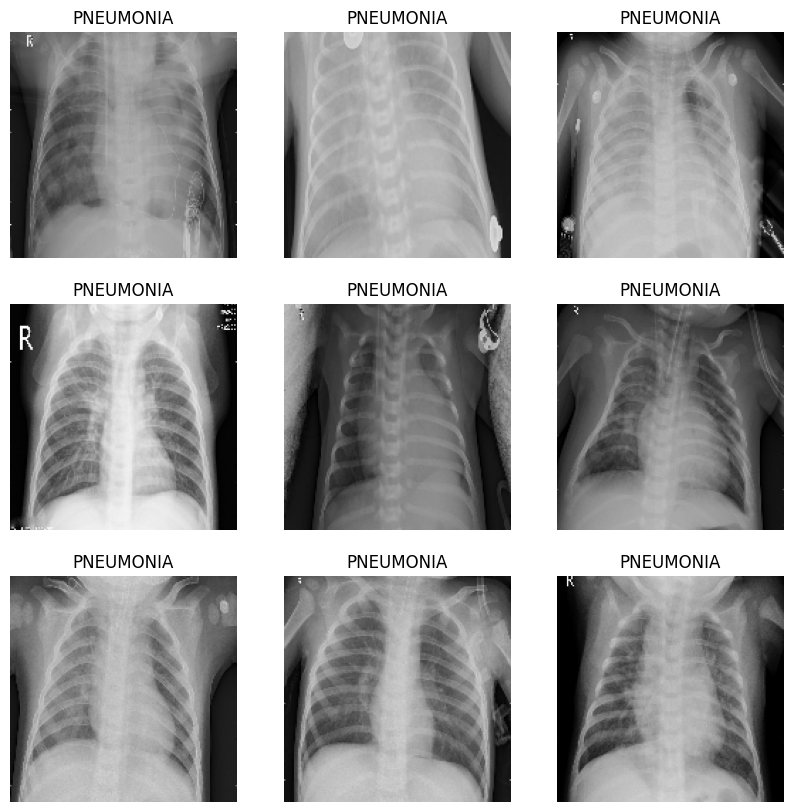

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
 for i in range(9):
     ax = plt.subplot(3, 3, i + 1)
     plt.imshow(images[i].numpy().astype("uint8"))
     plt.title(class_names[labels[i]])
     plt.axis("off")
for image_batch, labels_batch in train_ds:
 print(image_batch.shape)
 print(labels_batch.shape)
 break

In [14]:
#definig our CNN model with 3 convolutional layers and 3 max pooling layers 
model = Sequential([
 layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160,160,3)),
 layers.Conv2D(16, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(32, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(64, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Flatten(),
 layers.Dense(128, activation='relu'),
 layers.Dense(num_classes)
])
model.compile(optimizer='adam',
 
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

In [15]:
epochs=8
history = model.fit(
 train_ds,
 validation_data=validation_ds,
 epochs=epochs
    )
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/8
163/163 [==============================] - 49s 295ms/step - loss: 0.2259 - accuracy: 0.9082 - val_loss: 0.1904 - val_accuracy: 0.9375
Epoch 2/8
163/163 [==============================] - 46s 281ms/step - loss: 0.1112 - accuracy: 0.9578 - val_loss: 0.1204 - val_accuracy: 1.0000
Epoch 3/8
163/163 [==============================] - 45s 275ms/step - loss: 0.0873 - accuracy: 0.9668 - val_loss: 0.6179 - val_accuracy: 0.7500
Epoch 4/8
163/163 [==============================] - 48s 293ms/step - loss: 0.0582 - accuracy: 0.9783 - val_loss: 0.0286 - val_accuracy: 1.0000
Epoch 5/8
163/163 [==============================] - 45s 276ms/step - loss: 0.0421 - accuracy: 0.9862 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 6/8
163/163 [==============================] - 45s 275ms/step - loss: 0.0319 - accuracy: 0.9879 - val_loss: 0.1049 - val_accuracy: 0.9375
Epoch 7/8
163/163 [==============================] - 45s 274ms/step - loss: 0.0212 - accuracy: 0.9927 - val_loss: 0.0276 - val_accuracy:

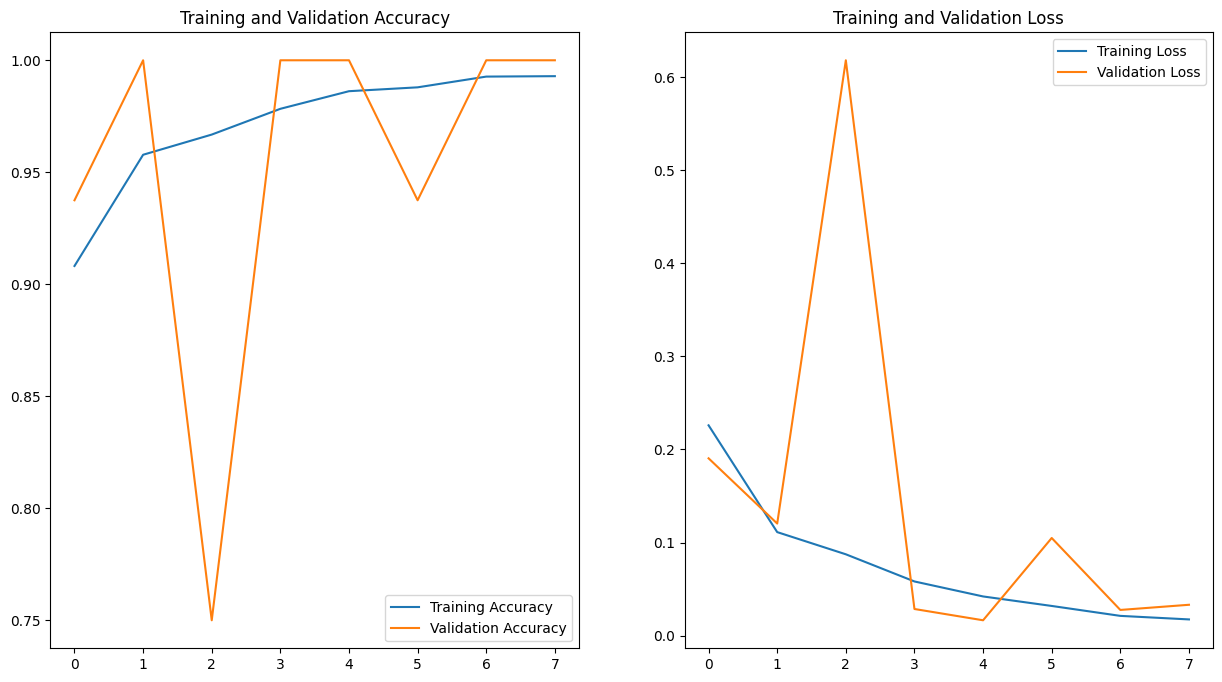

In [16]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 2s 80ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.36      0.52       234
   PNEUMONIA       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



20/20 [==============================] - 3s 108ms/step


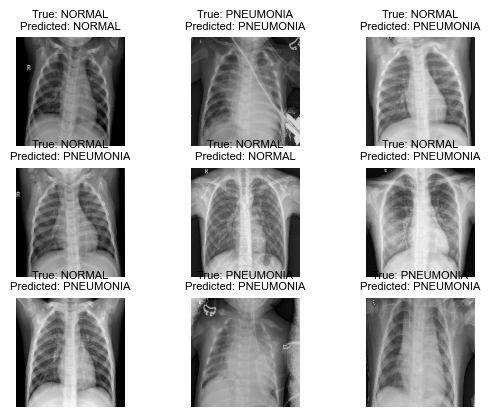

In [18]:
def convert_to_rgb(image, label):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image, label

test_ds_rgb = test_ds.map(convert_to_rgb)

predictions = model.predict(test_ds_rgb)
predicted_labels = tf.argmax(predictions, axis=1)

for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze()
        img = img / np.amax(img)  # normalize the image data to [0..1]
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}',fontsize=8, fontname='Arial')
        plt.axis('off')
    plt.show()


## data_augmentation

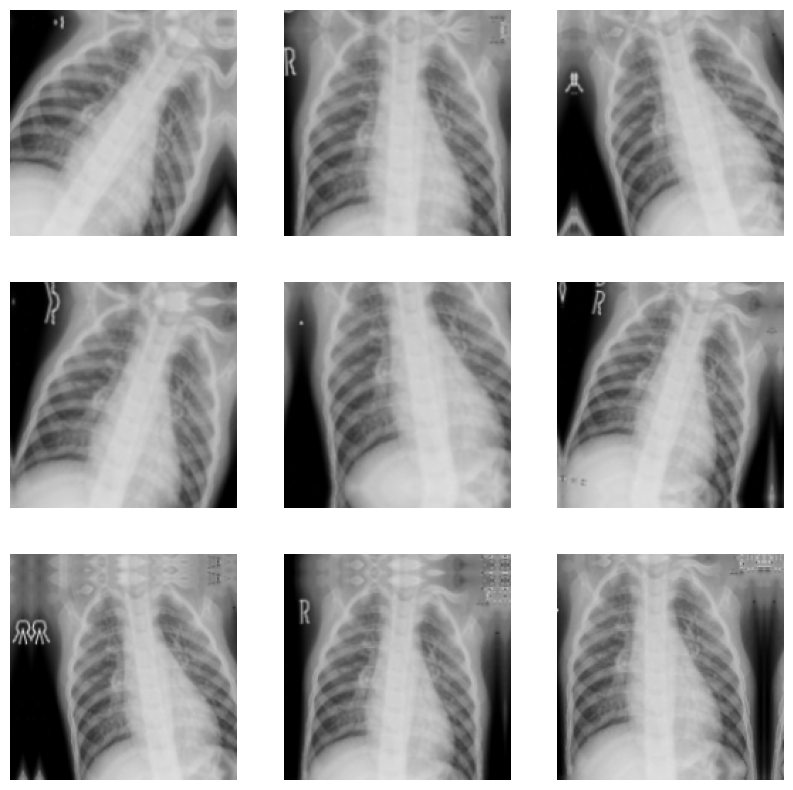

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)])
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [20]:
#definig our CNN model with 3 convolutional layers and 3 max pooling layers 
model = Sequential([
 layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160,160,3)),
 layers.experimental.preprocessing.RandomRotation(0.1),
 layers.experimental.preprocessing.RandomZoom(0.1),
 layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),   
 layers.Conv2D(16, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(32, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(64, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Flatten(),
 layers.Dense(128, activation='relu'),
 layers.Dense(num_classes)
])
model.compile(optimizer='adam',
 
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 160, 160, 3)       0         
                                                                 
 random_translation_1 (Rand  (None, 160, 160, 3)       0         
 omTranslation)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 80, 80, 16)       

In [21]:
epochs=8
history = model.fit(
 train_ds,
 validation_data=validation_ds,
 epochs=epochs
    )
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/8
163/163 [==============================] - 57s 342ms/step - loss: 0.5455 - accuracy: 0.7318 - val_loss: 0.5512 - val_accuracy: 0.6875
Epoch 2/8
163/163 [==============================] - 56s 345ms/step - loss: 0.3397 - accuracy: 0.8418 - val_loss: 0.6128 - val_accuracy: 0.6875
Epoch 3/8
163/163 [==============================] - 56s 341ms/step - loss: 0.2444 - accuracy: 0.8986 - val_loss: 0.4926 - val_accuracy: 0.8125
Epoch 4/8
163/163 [==============================] - 61s 373ms/step - loss: 0.2017 - accuracy: 0.9170 - val_loss: 0.4451 - val_accuracy: 0.8125
Epoch 5/8
163/163 [==============================] - 67s 412ms/step - loss: 0.1999 - accuracy: 0.9160 - val_loss: 0.4068 - val_accuracy: 0.8750
Epoch 6/8
163/163 [==============================] - 56s 346ms/step - loss: 0.1667 - accuracy: 0.9346 - val_loss: 0.5192 - val_accuracy: 0.8125
Epoch 7/8
163/163 [==============================] - 55s 339ms/step - loss: 0.1548 - accuracy: 0.9394 - val_loss: 0.2707 - val_accuracy:

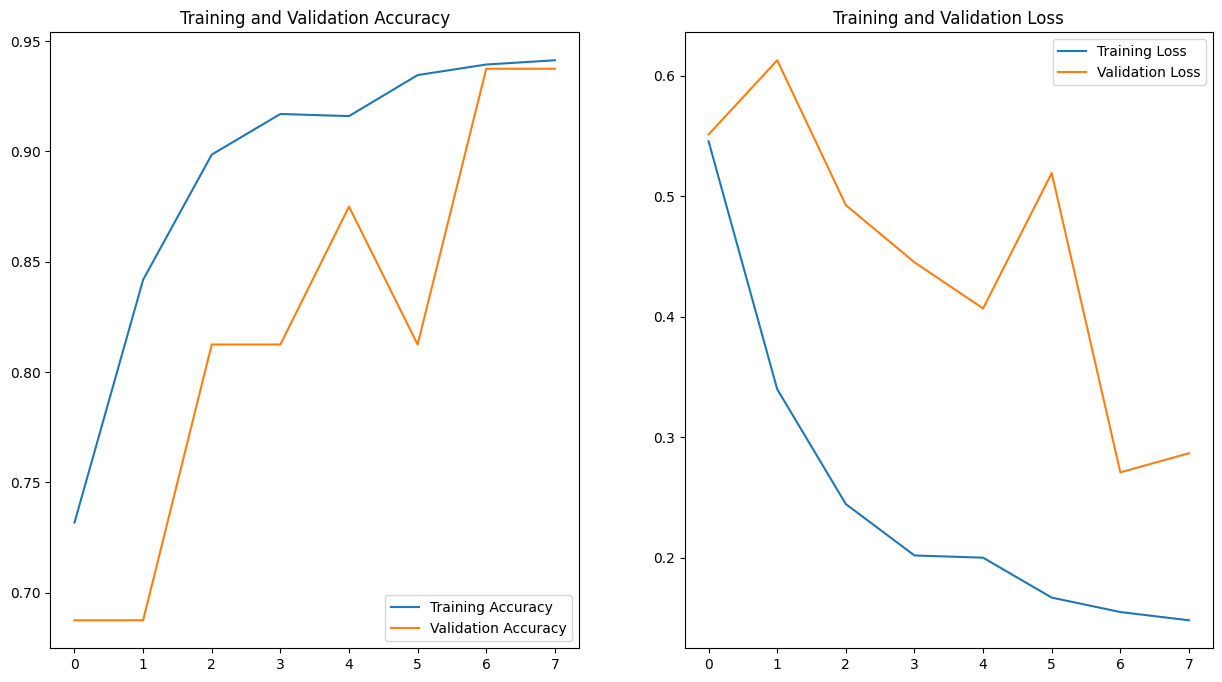

In [22]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 2s 83ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.69      0.80       234
   PNEUMONIA       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



20/20 [==============================] - 3s 108ms/step


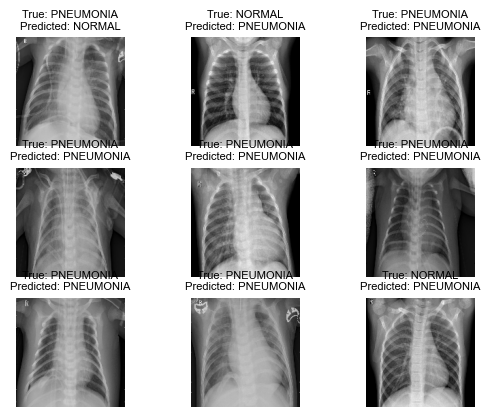

In [24]:
def convert_to_rgb(image, label):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image, label

test_ds_rgb = test_ds.map(convert_to_rgb)

predictions = model.predict(test_ds_rgb)
predicted_labels = tf.argmax(predictions, axis=1)

for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze()
        img = img / np.amax(img)  # normalize the image data to [0..1]
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}',fontsize=8, fontname='Arial')
        plt.axis('off')
    plt.show()


### Add Batch Normalizations and dropouts

In [25]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160,160,3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),   
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 160, 160, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 160, 160, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 80, 80, 16)       

In [26]:
epochs=8
history = model.fit(
 train_ds,
 validation_data=validation_ds,
 epochs=epochs
    )
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/8
163/163 [==============================] - 81s 486ms/step - loss: 0.7823 - accuracy: 0.8539 - val_loss: 73.5266 - val_accuracy: 0.5000
Epoch 2/8
163/163 [==============================] - 80s 493ms/step - loss: 0.2423 - accuracy: 0.9011 - val_loss: 49.7358 - val_accuracy: 0.5000
Epoch 3/8
163/163 [==============================] - 79s 482ms/step - loss: 0.2137 - accuracy: 0.9179 - val_loss: 29.0841 - val_accuracy: 0.5000
Epoch 4/8
163/163 [==============================] - 79s 481ms/step - loss: 0.1996 - accuracy: 0.9239 - val_loss: 6.3891 - val_accuracy: 0.5625
Epoch 5/8
163/163 [==============================] - 80s 490ms/step - loss: 0.1949 - accuracy: 0.9296 - val_loss: 1.0076 - val_accuracy: 0.7500
Epoch 6/8
163/163 [==============================] - 78s 479ms/step - loss: 0.1862 - accuracy: 0.9321 - val_loss: 1.2438 - val_accuracy: 0.5625
Epoch 7/8
163/163 [==============================] - 79s 485ms/step - loss: 0.1753 - accuracy: 0.9400 - val_loss: 21.2307 - val_accur

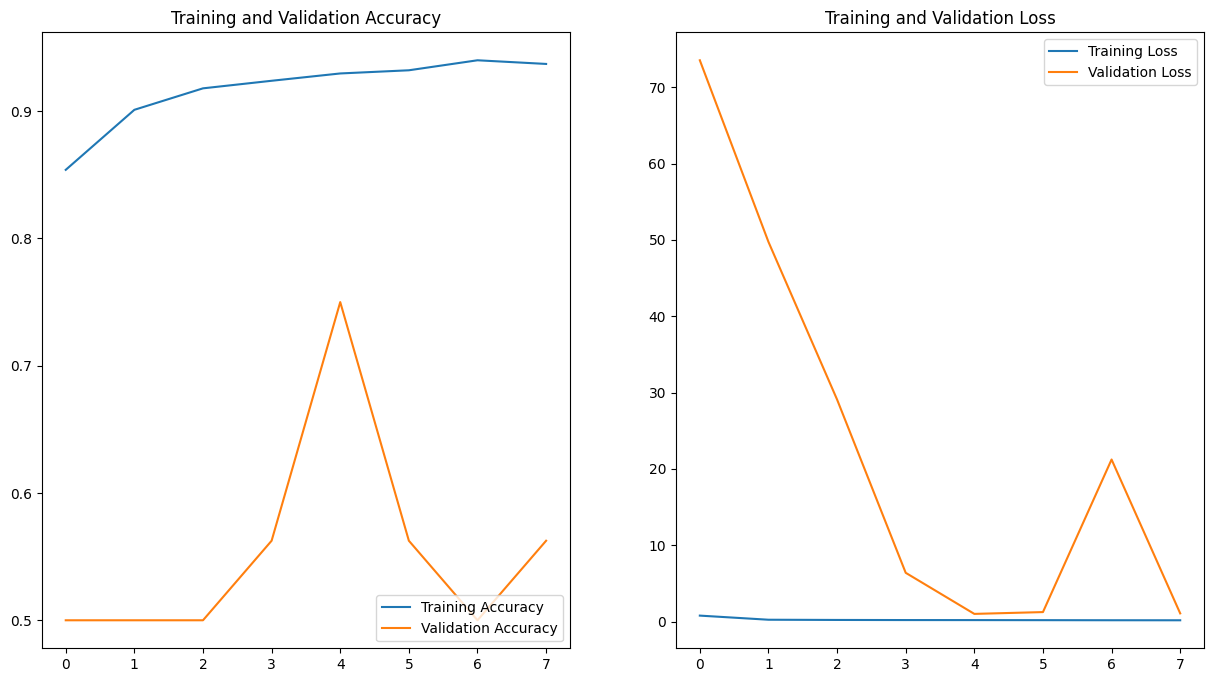

In [27]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 2s 112ms/step
              precision    recall  f1-score   support

      NORMAL       0.89      0.69      0.78       234
   PNEUMONIA       0.84      0.95      0.89       390

    accuracy                           0.85       624
   macro avg       0.86      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



In [29]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160,160,3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),   
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.2),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 conv2d_9 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 160, 160, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 80, 80, 16)       

In [30]:
epochs=8
history = model.fit(
 train_ds,
 validation_data=validation_ds,
 epochs=epochs
    )
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/8
163/163 [==============================] - 81s 490ms/step - loss: 0.7324 - accuracy: 0.8831 - val_loss: 59.9015 - val_accuracy: 0.5000
Epoch 2/8
163/163 [==============================] - 79s 488ms/step - loss: 0.1911 - accuracy: 0.9243 - val_loss: 36.8476 - val_accuracy: 0.5000
Epoch 3/8
163/163 [==============================] - 81s 497ms/step - loss: 0.1751 - accuracy: 0.9369 - val_loss: 7.8136 - val_accuracy: 0.5000
Epoch 4/8
163/163 [==============================] - 80s 492ms/step - loss: 0.1539 - accuracy: 0.9433 - val_loss: 2.1387 - val_accuracy: 0.6250
Epoch 5/8
163/163 [==============================] - 82s 502ms/step - loss: 0.1564 - accuracy: 0.9413 - val_loss: 0.7161 - val_accuracy: 0.6250
Epoch 6/8
163/163 [==============================] - 81s 494ms/step - loss: 0.1479 - accuracy: 0.9463 - val_loss: 0.7556 - val_accuracy: 0.6250
Epoch 7/8
163/163 [==============================] - 81s 497ms/step - loss: 0.1444 - accuracy: 0.9456 - val_loss: 0.7773 - val_accurac

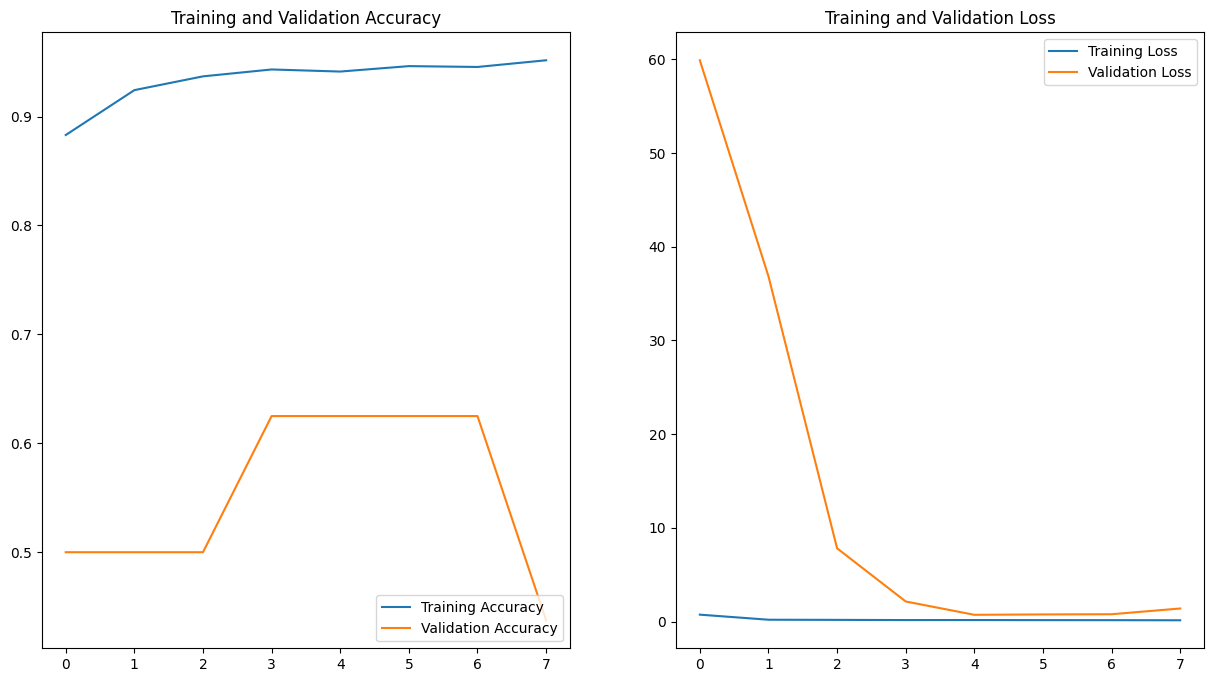

In [31]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 2s 107ms/step
              precision    recall  f1-score   support

      NORMAL       0.56      0.97      0.71       234
   PNEUMONIA       0.96      0.54      0.69       390

    accuracy                           0.70       624
   macro avg       0.76      0.75      0.70       624
weighted avg       0.81      0.70      0.70       624



### Increasing the number of Epochs to 12

In [33]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160,160,3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),   
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.2),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 conv2d_12 (Conv2D)          (None, 160, 160, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 160, 160, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 80, 80, 16)       

In [34]:
epochs=12
history = model.fit(
 train_ds,
 validation_data=validation_ds,
 epochs=epochs
    )
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/12
163/163 [==============================] - 81s 489ms/step - loss: 0.8925 - accuracy: 0.8719 - val_loss: 77.2894 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 80s 490ms/step - loss: 0.2075 - accuracy: 0.9204 - val_loss: 66.6873 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 80s 491ms/step - loss: 0.1798 - accuracy: 0.9296 - val_loss: 17.0560 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 83s 512ms/step - loss: 0.1683 - accuracy: 0.9413 - val_loss: 6.5059 - val_accuracy: 0.5625
Epoch 5/12
163/163 [==============================] - 89s 544ms/step - loss: 0.1598 - accuracy: 0.9431 - val_loss: 8.6911 - val_accuracy: 0.5000
Epoch 6/12
163/163 [==============================] - 81s 499ms/step - loss: 0.1482 - accuracy: 0.9490 - val_loss: 1.1992 - val_accuracy: 0.5625
Epoch 7/12
163/163 [==============================] - 81s 496ms/step - loss: 0.1393 - accuracy: 0.9519 - val_loss: 0.3930 - val

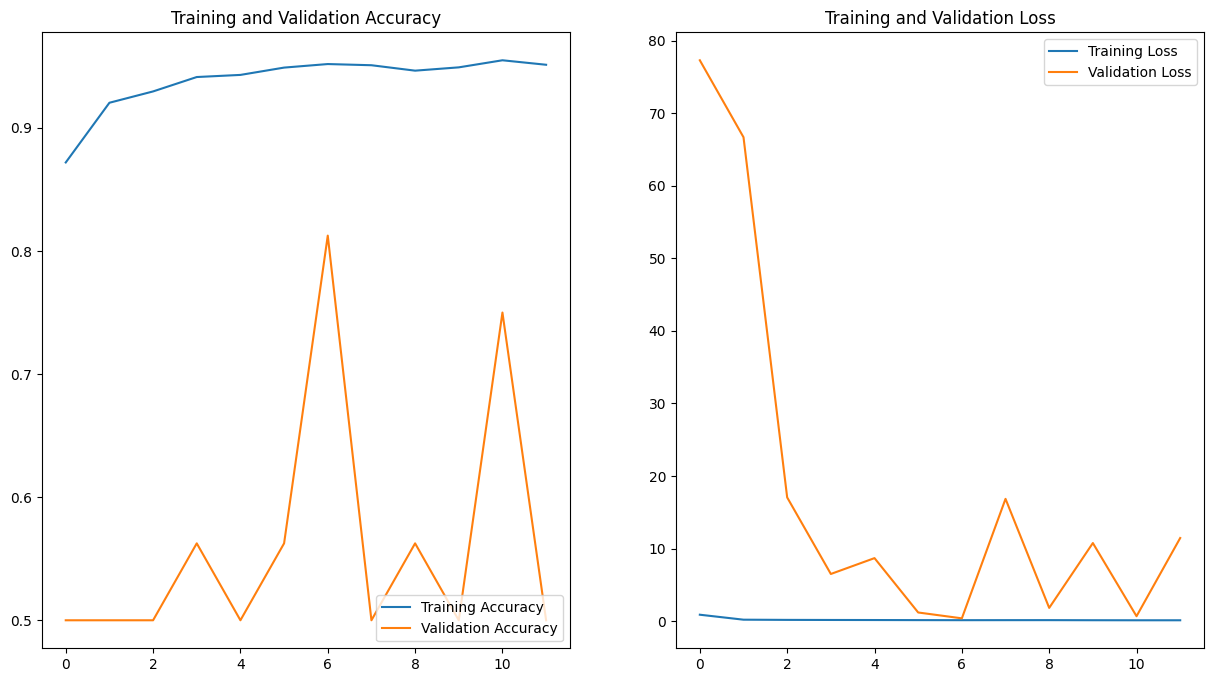

In [35]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 2s 105ms/step
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\750657\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\750657\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\750657\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [37]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160,160,3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),   
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.2),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_5 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 conv2d_15 (Conv2D)          (None, 160, 160, 16)      448       
                                                                 
 batch_normalization_9 (Bat  (None, 160, 160, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 80, 80, 16)       

In [38]:
epochs=10
history = model.fit(
 train_ds,
 validation_data=validation_ds,
 epochs=epochs
    )
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/10
163/163 [==============================] - 81s 488ms/step - loss: 1.0290 - accuracy: 0.8296 - val_loss: 13.6275 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 79s 486ms/step - loss: 0.2284 - accuracy: 0.9139 - val_loss: 7.0214 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 80s 491ms/step - loss: 0.1996 - accuracy: 0.9252 - val_loss: 6.5518 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 80s 489ms/step - loss: 0.1937 - accuracy: 0.9247 - val_loss: 0.4131 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 79s 486ms/step - loss: 0.1605 - accuracy: 0.9387 - val_loss: 0.5031 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 79s 485ms/step - loss: 0.1621 - accuracy: 0.9454 - val_loss: 3.8947 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 80s 491ms/step - loss: 0.1520 - accuracy: 0.9438 - val_loss: 0.4112 - val_a

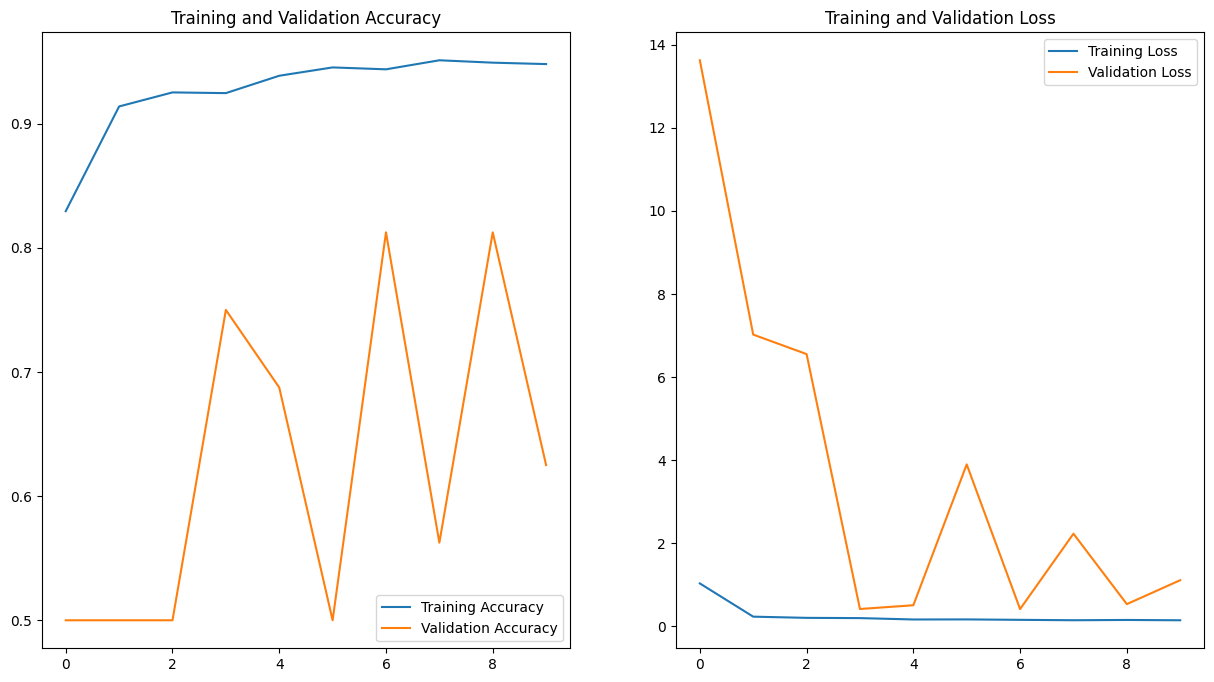

In [39]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 3s 128ms/step
              precision    recall  f1-score   support

      NORMAL       0.93      0.55      0.69       234
   PNEUMONIA       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.84      0.81      0.80       624



In [41]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
confusion_matrix = confusion_matrix(test_labels, predicted_labels)
print(confusion_matrix)


[[128 106]
 [ 10 380]]


In [42]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: >

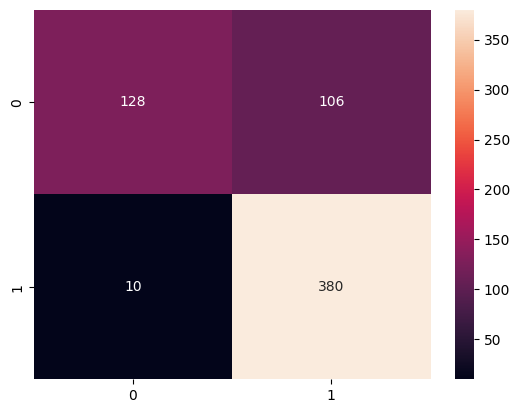

In [43]:
import seaborn as sns

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d')


<Axes: >

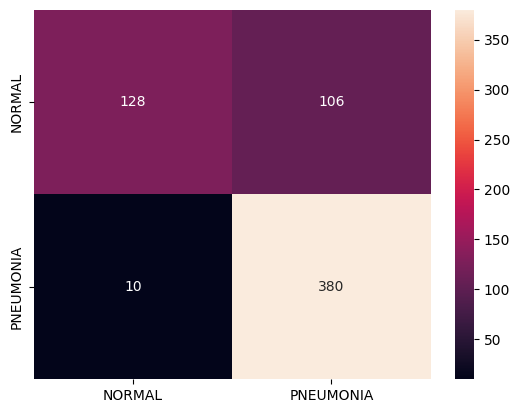

In [44]:
import seaborn as sns

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)


## Use of pretrained model

In [72]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
 include_top=False,
 weights='imagenet')
 
image_batch, label_batch = next(iter(train_ds))

# Check if your grayscale image has three channels
if len(image_batch.shape) == 4 and image_batch.shape[-1] == 3:
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)


(32, 5, 5, 1280)


In [73]:
num_classes = len(class_names)
output_layer = tf.keras.layers.Dense(num_classes)
num_classes
output_layer

In [74]:
base_model.trainable = False #to avoid override of weights the models has already learnt
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [75]:
#add prediction layer (Dense 2 ) representing the number of classes
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [76]:
#change the range from 0-255 to -1,1 for the pretrained model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [77]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs) 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])
 
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [78]:
len(model.trainable_variables)
initial_epochs = 8
loss0, accuracy0 = model.evaluate(validation_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_ds,
 epochs=initial_epochs,
 validation_data=validation_ds)

1/1 [==============================] - 1s 1s/step - loss: 1.1861 - accuracy: 0.5000
initial loss: 1.19
initial accuracy: 0.50
Epoch 1/8
163/163 [==============================] - 61s 359ms/step - loss: 0.5436 - accuracy: 0.7508 - val_loss: 0.6881 - val_accuracy: 0.5000
Epoch 2/8
163/163 [==============================] - 59s 360ms/step - loss: 0.3611 - accuracy: 0.8309 - val_loss: 0.6168 - val_accuracy: 0.6875
Epoch 3/8
163/163 [==============================] - 59s 364ms/step - loss: 0.3087 - accuracy: 0.8631 - val_loss: 0.4751 - val_accuracy: 0.7500
Epoch 4/8
163/163 [==============================] - 58s 355ms/step - loss: 0.2735 - accuracy: 0.8758 - val_loss: 0.4448 - val_accuracy: 0.7500
Epoch 5/8
163/163 [==============================] - 57s 352ms/step - loss: 0.2503 - accuracy: 0.8944 - val_loss: 0.4005 - val_accuracy: 0.7500
Epoch 6/8
163/163 [==============================] - 58s 353ms/step - loss: 0.2356 - accuracy: 0.8997 - val_loss: 0.3604 - val_accuracy: 0.7500
Epoch 7/8


In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [80]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 6s 271ms/step
              precision    recall  f1-score   support

      NORMAL       0.71      0.90      0.79       234
   PNEUMONIA       0.93      0.78      0.85       390

    accuracy                           0.82       624
   macro avg       0.82      0.84      0.82       624
weighted avg       0.84      0.82      0.82       624



In [81]:
base_model.trainable = True
base_model.summary()
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
 layer.trainable = False

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [82]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
 metrics=['accuracy'])

In [83]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
 epochs=total_epochs,
 initial_epoch=history.epoch[-1],
 validation_data=validation_ds
 )

Epoch 8/18
163/163 [==============================] - 94s 554ms/step - loss: 0.1866 - accuracy: 0.9270 - val_loss: 0.3588 - val_accuracy: 0.8750
Epoch 9/18
163/163 [==============================] - 87s 535ms/step - loss: 0.1520 - accuracy: 0.9436 - val_loss: 0.2733 - val_accuracy: 0.8750
Epoch 10/18
163/163 [==============================] - 82s 505ms/step - loss: 0.1378 - accuracy: 0.9450 - val_loss: 0.6741 - val_accuracy: 0.6875
Epoch 11/18
163/163 [==============================] - 84s 514ms/step - loss: 0.1179 - accuracy: 0.9555 - val_loss: 0.3442 - val_accuracy: 0.8125
Epoch 12/18
163/163 [==============================] - 85s 521ms/step - loss: 0.1118 - accuracy: 0.9561 - val_loss: 0.2396 - val_accuracy: 0.8750
Epoch 13/18
163/163 [==============================] - 83s 508ms/step - loss: 0.1075 - accuracy: 0.9590 - val_loss: 0.4864 - val_accuracy: 0.7500
Epoch 14/18
163/163 [==============================] - 83s 510ms/step - loss: 0.0962 - accuracy: 0.9628 - val_loss: 0.2537 - v

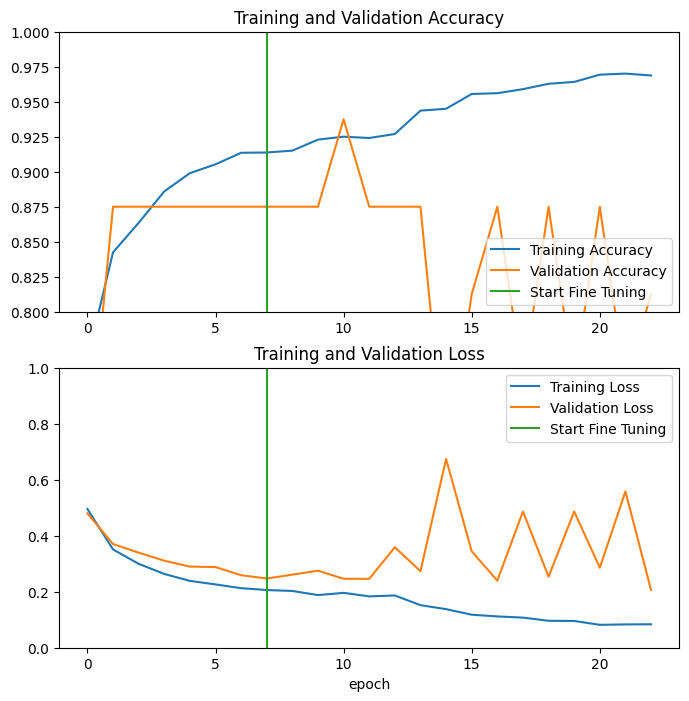

In [84]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
 plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
 plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [85]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the classification report
print(classification_report(test_labels, predicted_labels, target_names=class_names))

20/20 [==============================] - 6s 276ms/step
              precision    recall  f1-score   support

      NORMAL       0.92      0.85      0.88       234
   PNEUMONIA       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



20/20 [==============================] - 7s 290ms/step


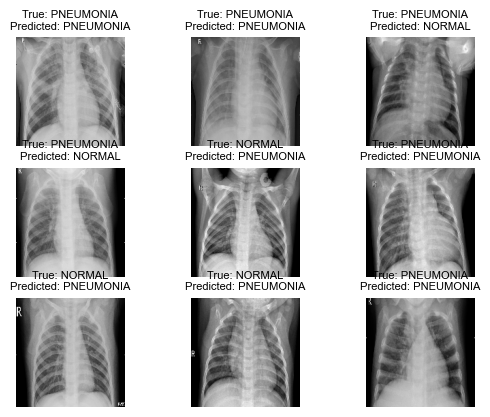

In [86]:
def convert_to_rgb(image, label):
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image, label

test_ds_rgb = test_ds.map(convert_to_rgb)

predictions = model.predict(test_ds_rgb)
predicted_labels = tf.argmax(predictions, axis=1)

for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze()
        img = img / np.amax(img)  # normalize the image data to [0..1]
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}', fontsize=8, fontname='Arial')
        plt.axis('off')
    plt.show()

In [88]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
confusion_matrix = confusion_matrix(test_labels, predicted_labels)
print(confusion_matrix)


[[ 88 146]
 [128 262]]


In [89]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: >

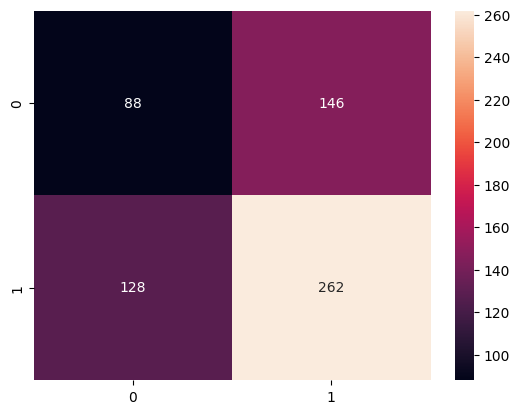

In [90]:
import seaborn as sns

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d')
